##### Importando as bibliotecas e Preparando os dados


In [30]:
# Importando as bibliotecas
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns

# Bibliotecas para o modelo de rede neural convolucional
import tensorflow as tf

# Bibliotecas para avaliação do modelo
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

tf.get_logger().setLevel('ERROR')


In [31]:
# Declarando variáveis

# Caminho dos datasets
path = './chest_xray/'
normal_classe = 'NORMAL'
pneumonia_classe = 'PNEUMONIA'

# Treino
treinamento_folder = os.path.join(path, 'train/')
treinamento_normal_dir = os.path.join(treinamento_folder, normal_classe)
treinamento_pneumonia_dir = os.path.join(treinamento_folder, pneumonia_classe)

# Teste
teste_folder = os.path.join(path, 'test/')
teste_normal_dir = os.path.join(teste_folder, normal_classe)
teste_pneumonia_dir = os.path.join(teste_folder, pneumonia_classe)

# Validação
validacao_folder = os.path.join(path, 'val/')
validacao_normal_dir = os.path.join(validacao_folder, normal_classe)
validacao_pneumonia_dir = os.path.join(validacao_folder, pneumonia_classe)

# Tamanho das imagens
img_width = 196
img_height = 196

# Variáveis para o treinamento
batch_size = 32
epochs = 100

class_names = [normal_classe, pneumonia_classe]


In [32]:
# Carregando os datasets

# Carregando o dataset de treinamento
dataset_treinamento = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Carregando o dataset de validação
dataset_validacao = tf.keras.preprocessing.image_dataset_from_directory(
    validacao_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Carregando o dataset de teste
dataset_teste = tf.keras.preprocessing.image_dataset_from_directory(
    teste_folder,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)


Found 5216 files belonging to 2 classes.
Found 33 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


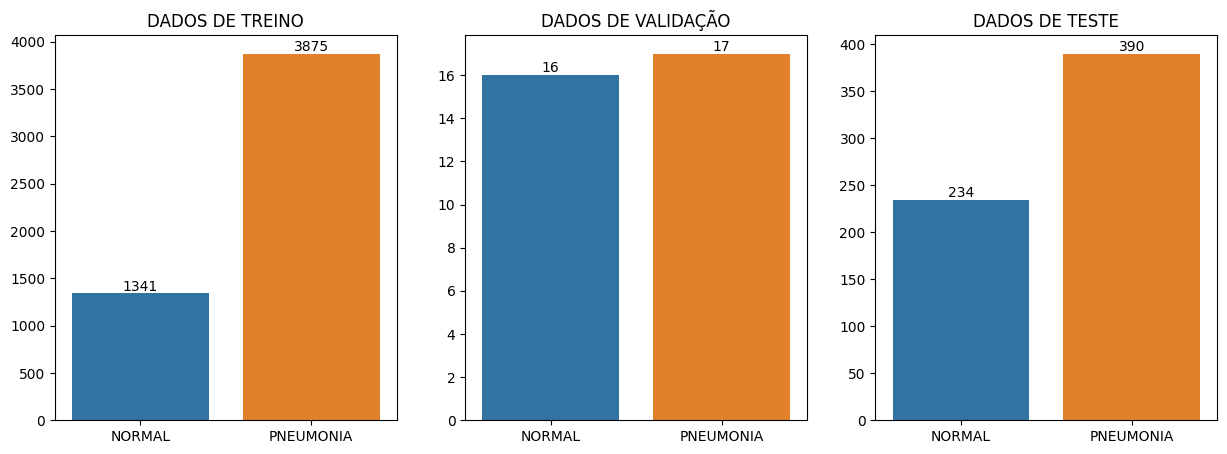

In [33]:
# Plotando graficos de barras com a quantidade de imagens de cada classe nos datasets
plt.figure(figsize=(15, 5))


def plot_quantidade(dir=[], title='', i=1):
    plt.subplot(1, 3, i)
    sns.barplot(x=class_names, y=[
                len(os.listdir(dir[0])), len(os.listdir(dir[1]))])
    plt.title(title)

    plt.text(0, len(os.listdir(dir[0])), len(
        os.listdir(dir[0])), ha='center', va='bottom')
    plt.text(1, len(os.listdir(dir[1])), len(
        os.listdir(dir[1])), ha='center', va='bottom')


plot_quantidade(
    [treinamento_normal_dir, treinamento_pneumonia_dir], 'DADOS DE TREINO', 1)

plot_quantidade(
    [validacao_normal_dir, validacao_pneumonia_dir], 'DADOS DE VALIDAÇÃO', 2)

plot_quantidade(
    [teste_normal_dir, teste_pneumonia_dir], 'DADOS DE TESTE', 3)


In [34]:
# Preparando os dados para o treinamento
def preprocess_image(image, label):
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)

    return image, label


dataset_treinamento = dataset_treinamento.map(preprocess_image)
dataset_validacao = dataset_validacao.map(preprocess_image)
dataset_teste = dataset_teste.map(preprocess_image)


##### Criação e treinamento do modelo


In [35]:
# Modelagem COM Transferência de Aprendizado
# Aqui vamos preparar o modelo de acordo com nossos requisitos

# Vamos preparar nossa camada de entrada para passar o tamanho da imagem. o padrão é (224,224,3). vamos alterá-lo para o tamanho da imagem que estamos usando.
input_layer = tf.keras.layers.Input(shape=(img_width, img_height, 3))

# Inicializando o modelo de transferência  com as propriedades apropriadas para nossas necessidades.
# Estamos passando parâmetros como:
# 1) weights='imagenet' - Usando isso, estamos carregando os pesos como os pesos originais.
# 2) input_tensor para passar o modelo usando input_tensor
# 3) Queremos alterar a última camada, então não estamos incluindo a camada superior

model_tl = tf.keras.applications.MobileNetV3Small(
    weights='imagenet', input_tensor=input_layer, include_top=False)

# Visualizando o sumário do modelo com nossas propriedades.
model_tl.summary()


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 196, 196, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 98, 98, 16)  64          ['Conv[0][0]']    

In [36]:
# Acessando a última camada do modelo e adicionando Flatten e Dense após ela

# Ultima camada do modelo
last_layer = model_tl.output

# Adicionando uma camada Flatten
flatten = tf.keras.layers.Flatten()(last_layer)

# Adicionando uma camada Dense para a camada de saída final
output_layer = tf.keras.layers.Dense(2, activation='softmax')(flatten)

# Criando o modelo com a camada de entrada e a camada de saída
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Sumário do modelo final com as camadas adicionadas
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 196, 196, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 98, 98, 16)  64          ['Conv[0][0]']             

In [37]:
# Congelando todas as camadas, exceto a última camada para impedir que o modelo de transferência do conhecimento seja treinado novamente

for layer in model.layers[:-1]:
    layer.trainable = False
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 196, 196, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 196, 196, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 98, 98, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 98, 98, 16)  64          ['Conv[0][0]']             

In [116]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03),
])



<Figure size 640x480 with 0 Axes>

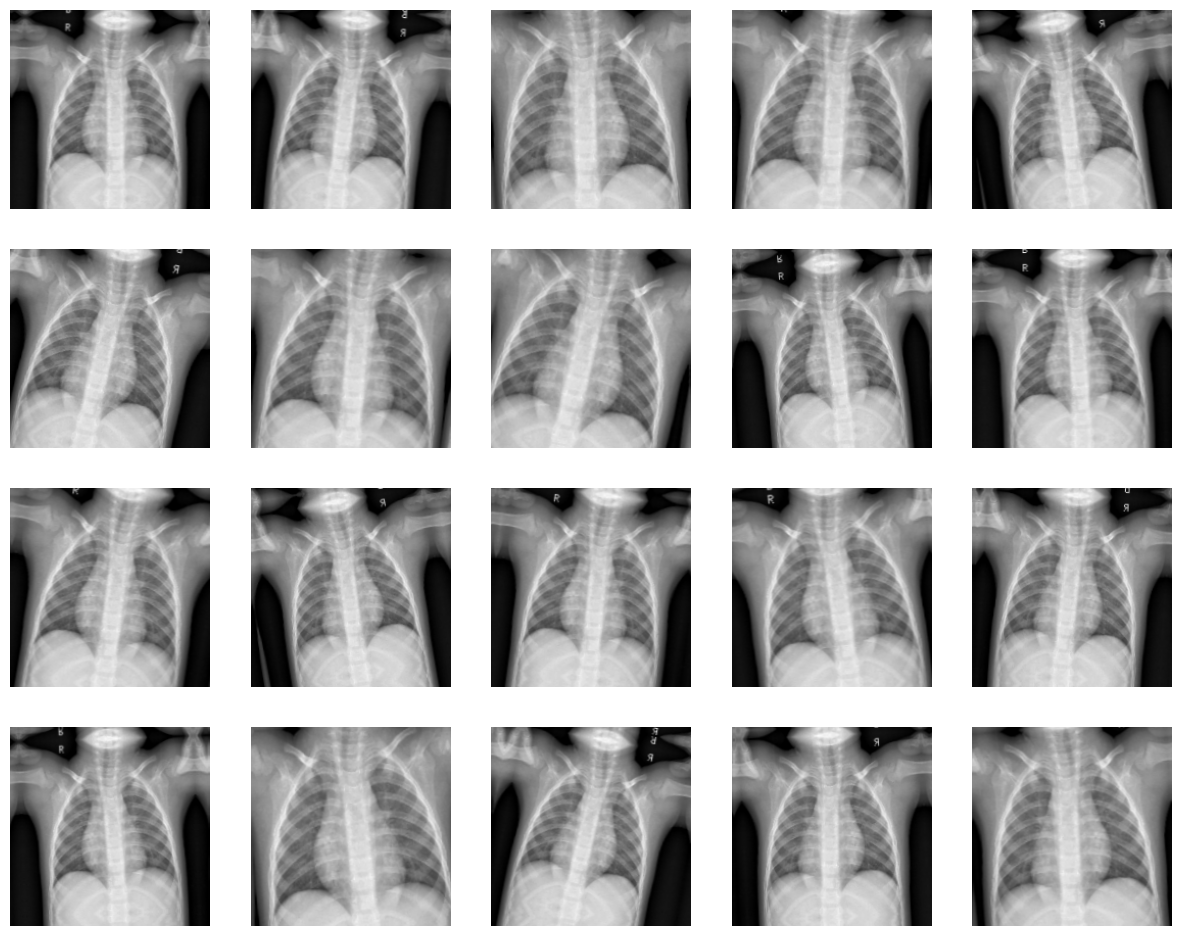

In [126]:
# Plotando imagens com Data Augmentation

def plot_dataset_data_augmentation(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))

    for features, _ in dataset.take(1):
        feature = features[0]

        for i in range(20):
            feature_data_augmentation = data_augmentation(
                feature, training=True)

            plt.subplot(5, 5, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation.numpy().astype('uint8'))


plot_dataset_data_augmentation(dataset_treinamento)


In [ ]:
# Aplicando Data Augmentation no modelo

model = tf.keras.Sequential([
    data_augmentation,
    model
])


In [39]:
# Compilando o modelo

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [40]:
# Treinamento do modelo

# Monitora a perda de validação e interrompe o treinamento quando a perda
# de validação não melhora por 5 épocas consecutivas para evitar overfitting
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    restore_best_weights=True  
)

history = model.fit(
    dataset_treinamento,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    validation_data=dataset_validacao,
    callbacks=[earlystopping],
)


Epoch 1/100
163/163 [==============================] - 44s 244ms/step - loss: 0.6997 - accuracy: 0.9034 - val_loss: 0.8544 - val_accuracy: 0.8182
Epoch 2/100
163/163 [==============================] - 43s 261ms/step - loss: 0.3152 - accuracy: 0.9459 - val_loss: 2.8241 - val_accuracy: 0.7879
Epoch 3/100
163/163 [==============================] - 44s 270ms/step - loss: 0.4056 - accuracy: 0.9440 - val_loss: 1.1528 - val_accuracy: 0.8788
Epoch 4/100
163/163 [==============================] - 45s 272ms/step - loss: 0.3245 - accuracy: 0.9530 - val_loss: 0.5367 - val_accuracy: 0.8485
Epoch 5/100
163/163 [==============================] - 45s 274ms/step - loss: 0.3245 - accuracy: 0.9590 - val_loss: 0.3519 - val_accuracy: 0.9091
Epoch 6/100
163/163 [==============================] - 45s 274ms/step - loss: 0.2817 - accuracy: 0.9603 - val_loss: 0.1994 - val_accuracy: 0.9697
Epoch 7/100
163/163 [==============================] - 46s 281ms/step - loss: 0.3591 - accuracy: 0.9590 - val_loss: 0.6790 -

<Figure size 640x480 with 0 Axes>

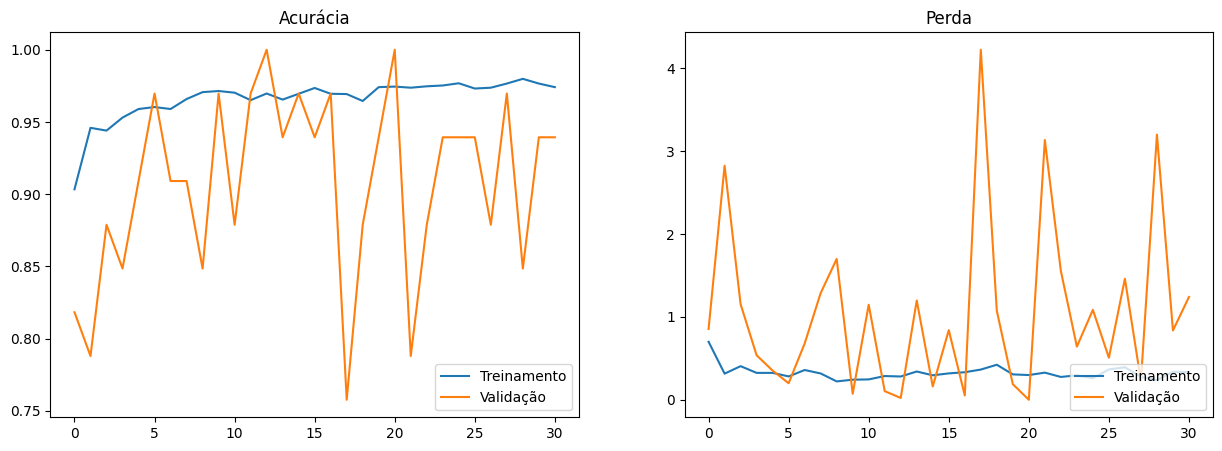

In [41]:
# Função para plotar gráficos de acurácia e loss do modelo
def plot_model(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.gcf().clear()
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('Acurácia')
    plt.plot(epochs_range, accuracy, label='Treinamento')
    plt.plot(epochs_range, val_accuracy, label='Validação')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Perda')
    plt.plot(epochs_range, loss, label='Treinamento')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.legend(loc='lower right')


plot_model(history)


##### Validação do modelo


In [48]:
# Função para plotar imagens e predições do modelo
def plot_results(dataset):

    features, labels = dataset.as_numpy_iterator().next()
    predictions = model.predict(features)

    num_rows = 4
    num_cols = 4
    total = num_rows*num_cols

    plt.gcf().clear()
    plt.figure(figsize=(2*num_cols, 2*num_rows))

    len = predictions.shape[0]

    arrayindex = random.sample(range(len), 25)

    for i in range(total):
        plt.subplot(num_rows, num_cols, i+1)
        index = arrayindex[i]

        predictions_array = predictions[index]
        true_label = np.argmax(labels, axis=1)[index]

        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.imshow(features[index].astype('uint8'), cmap=plt.cm.binary)

        predicted_label = np.argmax(predictions_array)

        if (predicted_label == true_label):
            color = 'green'
        else:
            color = 'red'

        percentage = 100*np.max(predictions_array)

        plt.xlabel("{} {:2.0f}% \n ({})".format(
            class_names[predicted_label], percentage, class_names[true_label]), color=color)

    plt.subplots_adjust(hspace=0.5)


1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

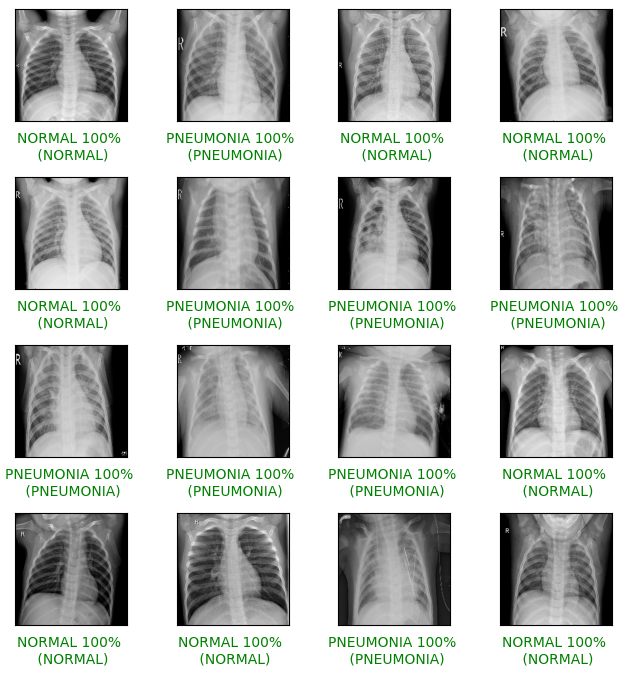

In [52]:
# Plotando os resultados do modelo no dataset de validacao

plot_results(dataset_validacao)


1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

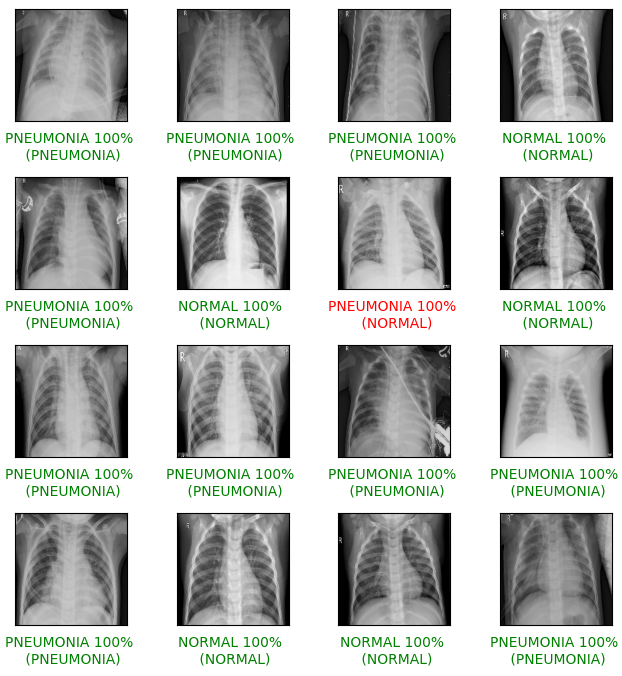

In [53]:
# Plotando os resultados do modelo no dataset de teste

plot_results(dataset_teste)

In [45]:
# Função para obter os resultados do modelo

def get_results(dataset):
    count = 0
    label_list = []
    prediction_list = []

    for features, labels in dataset:
        predictions = model.predict(features)
        for i in range(batch_size):
            label = np.argmax(labels[i])
            label_list.append(label)

            prediction_list.append(np.argmax(predictions[i]))
            count += 1

            if (i+1 == len(predictions)):
                break

    return label_list, prediction_list


val_labels, val_predictions = get_results(dataset_validacao)
test_labels, test_predictions = get_results(dataset_teste)


1/1 [==============================] - 0s 36ms/step


Porcentagem de acerto - Validação: 100%
Porcentagem de acerto - Teste: 92%


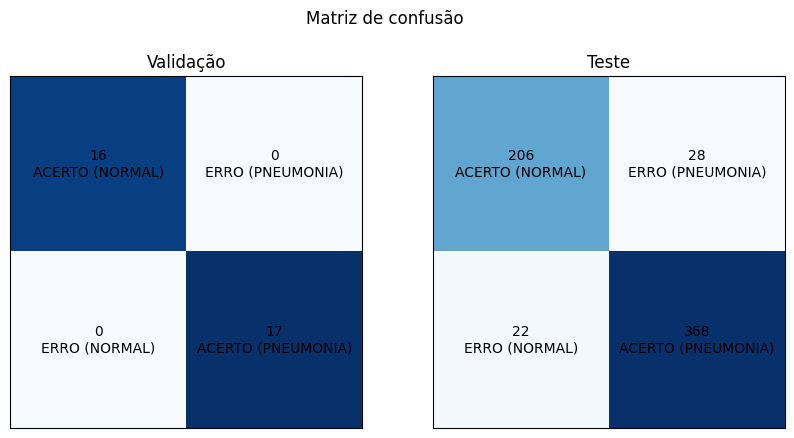

In [61]:
# Matriz de confusão

plt.figure(figsize=(10, 5))
plt.suptitle("Matriz de confusão")


def plot_confusion_matrix(predictions, labels, title='Confusion Matrix', i=1):
    plt.subplot(1, 2, i)

    # Matriz de confusão
    matrix = confusion_matrix(labels, predictions)

    porcentagem_acerto = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix) * 100

    print(f'Porcentagem de acerto - {title}: {round(porcentagem_acerto)}%')

    plt.imshow(matrix, cmap=plt.cm.Blues)

    # Adicionando os nomes das classes e os valores
    for i in range(2):
        for j in range(2):
            text = 'ACERTO' if i == j else 'ERRO'
            text_final = f'{matrix[i, j]}\n{text} ({class_names[i]})'
            plt.text(i, j, text_final, va='center', ha='center')

    plt.title(title)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)


plot_confusion_matrix(val_labels, val_predictions,
                      title='Validação', i=1)
plot_confusion_matrix(test_labels, test_predictions,
                      title='Teste', i=2)


(0.916400850611377, 0.911965811965812, 0.9140808301113645, None)

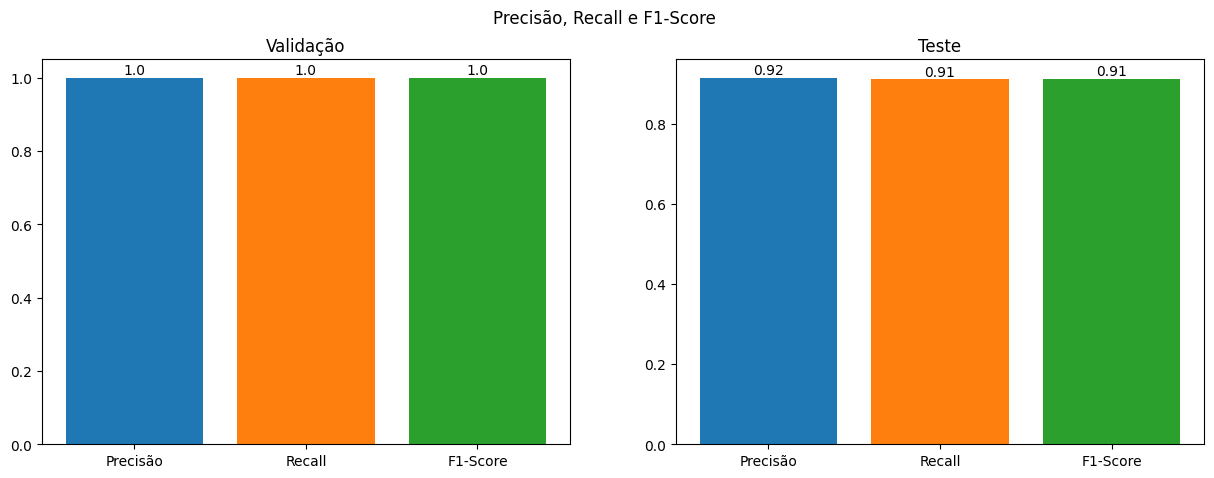

In [47]:
# Gráfico de precisão, recall e f1-score

plt.figure(figsize=(15, 5))
plt.suptitle("Precisão, Recall e F1-Score")


def plot_precision(predictions, labels, title='Precisão', i=1):
    precision = precision_recall_fscore_support(
        labels, predictions, average='macro')

    plt.subplot(1, 2, i)
    plt.bar(['Precisão'], precision[0])
    plt.bar(['Recall'], precision[1])
    plt.bar(['F1-Score'], precision[2])

    # Exibindo os valores de precisão, recall e f1-score
    plt.text(0, precision[0], round(precision[0], 2), ha='center', va='bottom')
    plt.text(1, precision[1], round(precision[1], 2), ha='center', va='bottom')
    plt.text(2, precision[2], round(precision[2], 2), ha='center', va='bottom')
    plt.title(title)
    return precision


plot_precision(val_predictions, val_labels,
               title='Validação', i=1)
plot_precision(test_predictions, test_labels,
               title='Teste', i=2)
